In [6]:
# %% [markdown]
"""
## Cell 1: Import Libraries and Set Up the Environment

We import all the necessary libraries. We use:
- `numpy` and `pandas` for data manipulation.
- `matplotlib` for plotting.
- `tensorflow.keras` to build our neural network model.
- `matminer` to load and featurize the dataset.

We also set random seeds for reproducibility.
"""

'\n## Cell 1: Import Libraries and Set Up the Environment\n\nWe import all the necessary libraries. We use:\n- `numpy` and `pandas` for data manipulation.\n- `matplotlib` for plotting.\n- `tensorflow.keras` to build our neural network model.\n- `matminer` to load and featurize the dataset.\n\nWe also set random seeds for reproducibility.\n'

In [7]:
# %% [markdown]
"""
# Uncertainty Estimation in Materials Modeling with Simple Regression Algorithms

In materials informatics, knowing *how confident* a model is about its predictions is just as important as the prediction itself. In this notebook, we explore two types of uncertainty:

1. **Aleatoric Uncertainty:**
   The noise inherent in the data (e.g., measurement errors, experimental noise). This uncertainty is irreducible.

2. **Epistemic Uncertainty:**
   The uncertainty due to our limited knowledge or limited data. This uncertainty can be reduced by gathering more data or using better models.

We will use the **Double Perovskites Gap Dataset** from Matminer. This dataset contains information about double perovskite materials (including their chemical formulas and elemental labels) along with the band gap values. We aim to predict the band gap using three simple regression methods:
- Random Forest Regression
- Polynomial Regression (using linear regression on transformed features)
- Support Vector Regression (SVR)

For each model, we will:
- Split the data into training, calibration, and test sets.
- Estimate *epistemic uncertainty* from ensemble predictions (using the natural ensemble in Random Forest or bootstrap resampling for the other methods).
- Estimate *aleatoric uncertainty* using the residuals on a calibration set.
- Plot the predicted values and uncertainty intervals.
- Discuss strategies to identify and reduce these uncertainties.

Let's get started!
"""

"\n# Uncertainty Estimation in Materials Modeling with Simple Regression Algorithms\n\nIn materials informatics, knowing *how confident* a model is about its predictions is just as important as the prediction itself. In this notebook, we explore two types of uncertainty:\n\n1. **Aleatoric Uncertainty:**  \n   The noise inherent in the data (e.g., measurement errors, experimental noise). This uncertainty is irreducible.\n\n2. **Epistemic Uncertainty:**  \n   The uncertainty due to our limited knowledge or limited data. This uncertainty can be reduced by gathering more data or using better models.\n\nWe will use the **Double Perovskites Gap Dataset** from Matminer. This dataset contains information about double perovskite materials (including their chemical formulas and elemental labels) along with the band gap values. We aim to predict the band gap using three simple regression methods:\n- Random Forest Regression\n- Polynomial Regression (using linear regression on transformed features

In [8]:
!pip install matminer

In [9]:
# %% [markdown]
"""
## Cell 1: Import Libraries and Set Up the Environment

We import the necessary libraries for data manipulation, plotting, regression modeling, and featurization. We also set random seeds for reproducibility.
"""

# %% [code]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

# Machine learning models and utilities
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

# Matminer for dataset and featurization
from matminer.datasets import load_dataset
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import ElementProperty

# Set random seeds and ignore warnings for clarity
np.random.seed(42)
warnings.filterwarnings("ignore")


In [10]:
# %% [markdown]
"""
## Cell 2: Load the Double Perovskites Gap Dataset

We load the dataset using Matminer's `load_dataset` function. The dataset contains the following key columns:
- `formula`: The chemical formula of the double perovskite.
- `a_1, b_1, a_2, b_2`: Elemental labels.
- `gap`: The band gap (target variable).

If the dataset is not present locally, it will be downloaded.
"""

# %% [code]
df_perovskites = load_dataset("double_perovskites_gap", download_if_missing=True)
print("Double Perovskites Gap Dataset Shape:", df_perovskites.shape)
print(df_perovskites.head(10))

Fetching double_perovskites_gap.json.gz from https://ndownloader.figshare.com/files/13309157 to /usr/local/lib/python3.11/dist-packages/matminer/datasets/double_perovskites_gap.json.gz


Fetching https://ndownloader.figshare.com/files/13309157 in MB: 0.020479999999999998MB [00:00, 17.01MB/s]     

Double Perovskites Gap Dataset Shape: (1306, 6)
      formula a_1 b_1 a_2 b_2  gap gllbsc
0  AgNbLaAlO6  Ag  Nb  La  Al    4.164543
1  AgNbLaGaO6  Ag  Nb  La  Ga    4.454629
2  AgNbLaInO6  Ag  Nb  La  In    4.192522
3  AgNbMgTiO6  Ag  Nb  Mg  Ti    3.963857
4  AgNbSnTiO6  Ag  Nb  Sn  Ti    2.881239
5   AgNbYAlO6  Ag  Nb   Y  Al    3.958215
6  AgTaAgNbO6  Ag  Ta  Ag  Nb    3.367340
7  AgTaBaSnO6  Ag  Ta  Ba  Sn    4.115528
8  AgTaBaTiO6  Ag  Ta  Ba  Ti    3.651875
9  AgTaCaGeO6  Ag  Ta  Ca  Ge    4.596742


Missing values per column:
formula       0
a_1           0
b_1           0
a_2           0
b_2           0
gap gllbsc    0
dtype: int64

Statistical summary of 'gap':
count    1306.000000
mean        4.012035
std         1.581775
min         0.106620
25%         2.786297
50%         4.074557
75%         5.090252
max         8.343255
Name: gap gllbsc, dtype: float64


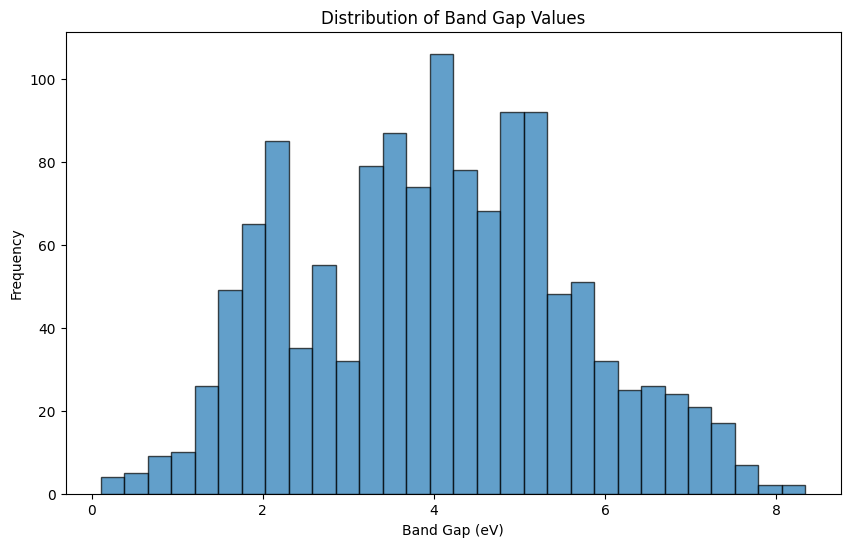

In [14]:
# %% [markdown]
"""
## Cell 3: Exploratory Data Analysis (EDA)

Before modeling, we explore the dataset:
- Check for missing values.
- Look at summary statistics of the target variable (`gap`).
- Visualize the distribution of the band gap.

This step is essential because data quality and noise levels directly affect our uncertainty estimates.
"""

# %% [code]
# Check for missing values in each column
print("Missing values per column:")
print(df_perovskites.isnull().sum())

# Describe the target variable (band gap)
print("\nStatistical summary of 'gap':")
print(df_perovskites['gap gllbsc'].describe())

# Plot histogram of the band gap values
plt.figure(figsize=(10, 6))
plt.hist(df_perovskites['gap gllbsc'], bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Band Gap (eV)")
plt.ylabel("Frequency")
plt.title("Distribution of Band Gap Values")
plt.show()


In [15]:
# %% [markdown]
"""
## Cell 4: Data Cleaning and Feature Engineering

We need to convert the chemical formulas into numerical features. Here, we:
1. Convert the `formula` column into a composition object.
2. Use the `ElementProperty` featurizer (with the "magpie" preset) to generate useful descriptors.
3. Drop columns that are not needed for modeling.

Good features reduce epistemic uncertainty by giving the model informative input.
"""

# %% [code]
# Copy the dataframe for featurization
df_features = df_perovskites.copy()

# Convert 'formula' to a pymatgen Composition object
str_to_comp = StrToComposition(target_col_id="composition")
df_features = str_to_comp.featurize_dataframe(df_features, "formula")

# Generate elemental property features using the "magpie" preset
ep_feat = ElementProperty.from_preset("magpie")
df_features = ep_feat.featurize_dataframe(df_features, col_id="composition")

# Drop columns not used for regression (original formula and composition)
df_features = df_features.drop(columns=["formula", "composition"])

# Display the new feature set
print("Featurized DataFrame:")
print(df_features.head())

StrToComposition:   0%|          | 0/1306 [00:00<?, ?it/s]

ElementProperty:   0%|          | 0/1306 [00:00<?, ?it/s]

Featurized DataFrame:
  a_1 b_1 a_2 b_2  gap gllbsc  MagpieData minimum Number  \
0  Ag  Nb  La  Al    4.164543                        8.0   
1  Ag  Nb  La  Ga    4.454629                        8.0   
2  Ag  Nb  La  In    4.192522                        8.0   
3  Ag  Nb  Mg  Ti    3.963857                        8.0   
4  Ag  Nb  Sn  Ti    2.881239                        8.0   

   MagpieData maximum Number  MagpieData range Number  MagpieData mean Number  \
0                       57.0                     49.0                    20.6   
1                       57.0                     49.0                    22.4   
2                       57.0                     49.0                    24.2   
3                       47.0                     39.0                    17.0   
4                       50.0                     42.0                    20.8   

   MagpieData avg_dev Number  ...  MagpieData range GSmagmom  \
0                      16.64  ...                   0.000000   
1 

In [19]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.2 MB/s eta 0:00:00


In [20]:
import category_encoders as ce
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [22]:
# %% [markdown]
"""
## Cell 5: Data Splitting and Normalization

We split the data into three parts:
- **Training Set:** For model training.
- **Calibration Set:** For estimating aleatoric uncertainty (from residual errors).
- **Test Set:** For evaluating predictions and uncertainties.

After splitting, we normalize the features with a standard scaler.
"""

# %% [code]
# Define X (features) and y (target: band gap)
X = df_features.drop(columns=["gap gllbsc"])
y = df_features["gap gllbsc"]

# Split data: 60% training, 20% calibration, 20% testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_cal, X_test, y_cal, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Identify categorical columns (e.g., columns containing elemental symbols)
categorical_cols = ['a_1', 'b_1', 'a_2', 'b_2']  # Replace with your actual categorical columns

# Create a OneHotEncoder object
encoder = ce.OneHotEncoder(cols=categorical_cols, handle_unknown='ignore')

# Fit and transform the encoder on the training data
X_train = encoder.fit_transform(X_train)
X_cal = encoder.transform(X_cal)
X_test = encoder.transform(X_test)

# Now apply StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_cal_scaled = scaler.transform(X_cal)
X_test_scaled = scaler.transform(X_test)

In [23]:
# %% [markdown]
"""
## Cell 6: Estimating Aleatoric Uncertainty Using a Calibration Set

For all our models, we assume that the irreducible noise (aleatoric uncertainty) can be approximated by the average absolute residual error on a calibration set. Here, we define a helper function that computes this error.

*Note:* This is a simplified approach. In real applications, aleatoric uncertainty might be input-dependent.
"""

# %% [code]
def compute_aleatoric_uncertainty(y_true, y_pred, quantile=0.90):
    """
    Compute a constant aleatoric uncertainty estimate from calibration residuals.
    We use the quantile (e.g., 90th percentile) of absolute residual errors.

    Parameters:
    - y_true: True target values.
    - y_pred: Predicted target values.
    - quantile: The quantile to use for the residual distribution.

    Returns:
    - A scalar representing the aleatoric uncertainty.
    """
    residuals = np.abs(y_true - y_pred)
    return np.quantile(residuals, quantile)

Estimated Aleatoric Uncertainty (RF): 0.5986954334599979


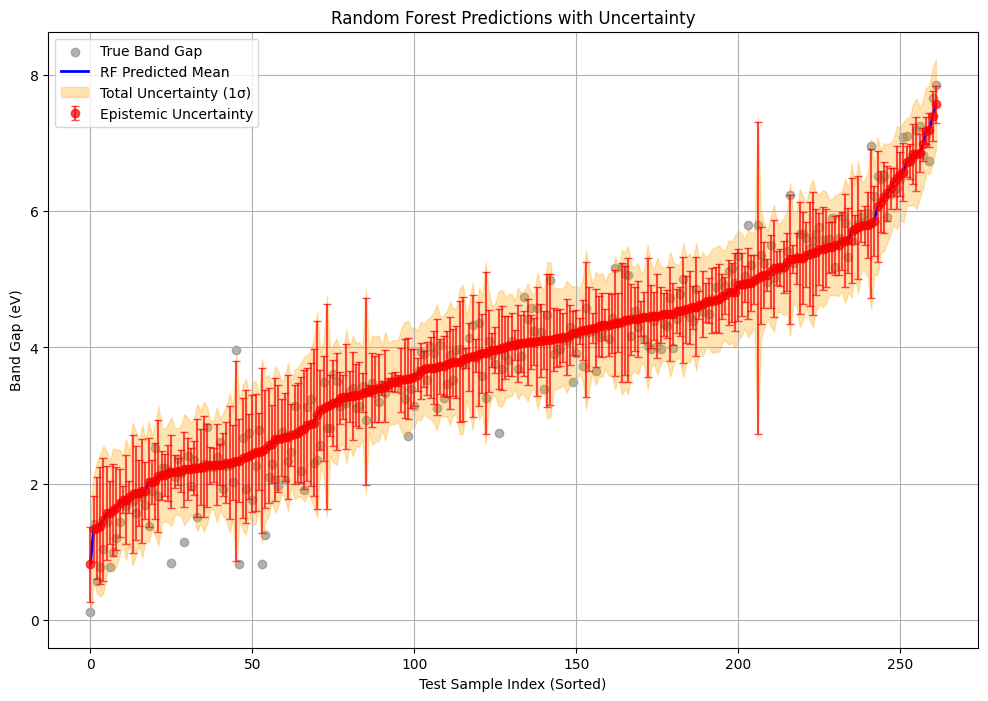

In [24]:
# %% [markdown]
"""
## Cell 7: Model 1 – Random Forest Regression

Random Forests are ensemble methods that build many decision trees. Each tree gives a prediction, and the average is the final prediction. We can use the predictions from individual trees to estimate **epistemic uncertainty** (the spread among trees).

For aleatoric uncertainty, we use our calibration set residual error.
"""

# %% [code]
# Train RandomForestRegressor on training data
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Obtain predictions on the calibration set
y_cal_pred_rf = rf_model.predict(X_cal_scaled)
aleatoric_rf = compute_aleatoric_uncertainty(y_cal, y_cal_pred_rf)
print("Estimated Aleatoric Uncertainty (RF):", aleatoric_rf)

# For test predictions, get predictions from all trees
tree_preds = np.array([tree.predict(X_test_scaled) for tree in rf_model.estimators_])
# Epistemic uncertainty: variance across tree predictions
epistemic_rf = np.var(tree_preds, axis=0)
# Mean prediction over trees
y_test_pred_rf = np.mean(tree_preds, axis=0)
# Total uncertainty: add constant aleatoric uncertainty squared (variance) to epistemic variance
total_rf = epistemic_rf + aleatoric_rf**2

# %% [markdown]
"""
### Plotting Random Forest Predictions and Uncertainty

We plot:
- True band gap (scatter points).
- Predicted band gap (line).
- Uncertainty band (±1 standard deviation from the square root of total variance).
- Epistemic uncertainty as error bars (derived from tree prediction variance).

The aleatoric uncertainty is a constant added in quadrature.
"""

# %% [code]
# Sort test indices for a smooth plot
sort_idx_rf = np.argsort(y_test_pred_rf)
x_axis_rf = np.arange(len(y_test_pred_rf))

plt.figure(figsize=(12, 8))
plt.scatter(x_axis_rf, y_test.values[sort_idx_rf], color='gray', alpha=0.6, label="True Band Gap")
plt.plot(x_axis_rf, y_test_pred_rf[sort_idx_rf], 'b-', linewidth=2, label="RF Predicted Mean")
plt.fill_between(x_axis_rf,
                 y_test_pred_rf[sort_idx_rf] - np.sqrt(total_rf[sort_idx_rf]),
                 y_test_pred_rf[sort_idx_rf] + np.sqrt(total_rf[sort_idx_rf]),
                 color='orange', alpha=0.3, label="Total Uncertainty (1σ)")
plt.errorbar(x_axis_rf, y_test_pred_rf[sort_idx_rf],
             yerr=np.sqrt(epistemic_rf[sort_idx_rf]),
             fmt='o', color='red', alpha=0.7, capsize=3, label="Epistemic Uncertainty")
plt.xlabel("Test Sample Index (Sorted)")
plt.ylabel("Band Gap (eV)")
plt.title("Random Forest Predictions with Uncertainty")
plt.legend()
plt.grid(True)
plt.show()

Estimated Aleatoric Uncertainty (Poly): 1.6808095523368967


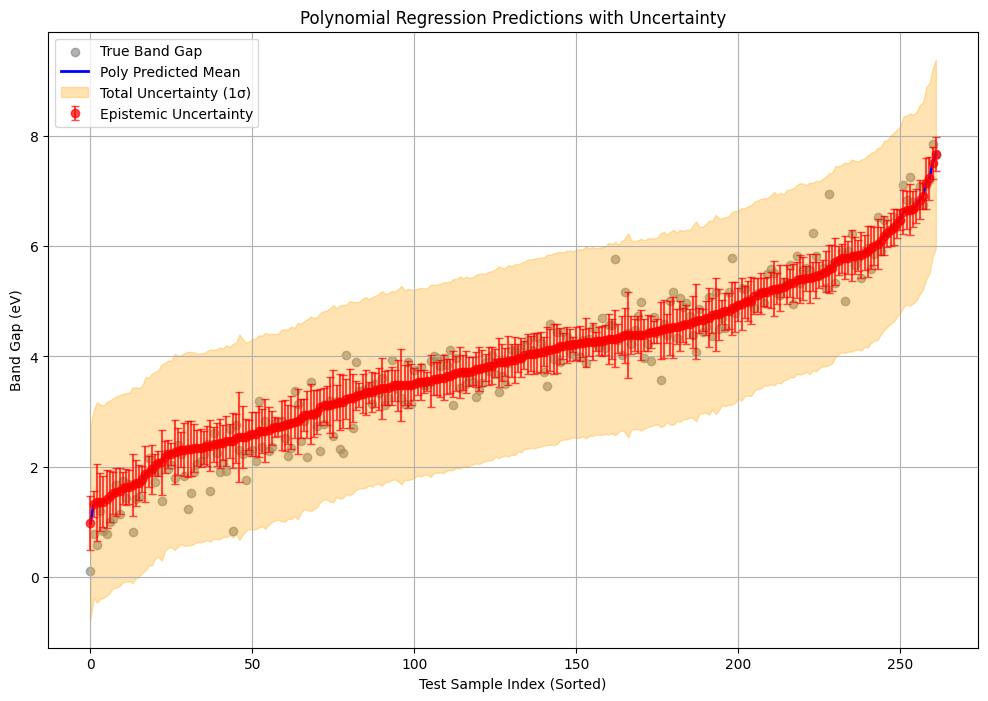

In [25]:

# %% [markdown]
"""
## Cell 8: Model 2 – Polynomial Regression

We now use Polynomial Regression to capture non-linear relationships. We use a fixed polynomial degree (e.g., degree 2 or 3). Since ordinary least squares does not provide ensemble predictions, we build a bootstrap ensemble:
- We repeatedly sample (with replacement) from the training set, fit a polynomial regression, and store predictions.
- The variance among these predictions gives the **epistemic uncertainty**.
- The **aleatoric uncertainty** is computed on the calibration set using the median residual error.

This approach simulates the uncertainty due to the model selection.
"""

# %% [code]
# Set degree for polynomial features
poly_degree = 2
poly = PolynomialFeatures(degree=poly_degree)

# Transform training features
X_train_poly = poly.fit_transform(X_train_scaled)
X_cal_poly = poly.transform(X_cal_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Define number of bootstrap samples
n_bootstrap = 100

# Collect ensemble predictions for test set
boot_preds_poly = []
for i in range(n_bootstrap):
    # Bootstrap sample from training data
    idx = np.random.choice(range(X_train_poly.shape[0]), size=X_train_poly.shape[0], replace=True)
    X_boot = X_train_poly[idx]
    y_boot = y_train.values[idx]
    model_poly = LinearRegression()
    model_poly.fit(X_boot, y_boot)
    boot_preds_poly.append(model_poly.predict(X_test_poly))

boot_preds_poly = np.array(boot_preds_poly)
y_test_pred_poly = np.mean(boot_preds_poly, axis=0)
epistemic_poly = np.var(boot_preds_poly, axis=0)

# Compute aleatoric uncertainty from calibration set
# Fit one polynomial regression model on full training data
model_poly_full = LinearRegression()
model_poly_full.fit(X_train_poly, y_train)
y_cal_pred_poly = model_poly_full.predict(X_cal_poly)
aleatoric_poly = compute_aleatoric_uncertainty(y_cal, y_cal_pred_poly)
total_poly = epistemic_poly + aleatoric_poly**2

print("Estimated Aleatoric Uncertainty (Poly):", aleatoric_poly)

# %% [markdown]
"""
### Plotting Polynomial Regression Predictions and Uncertainty

We sort the test predictions and plot the predicted mean, with an uncertainty band (using the combined variance) and error bars showing the epistemic uncertainty.
"""

# %% [code]
sort_idx_poly = np.argsort(y_test_pred_poly)
x_axis_poly = np.arange(len(y_test_pred_poly))

plt.figure(figsize=(12, 8))
plt.scatter(x_axis_poly, y_test.values[sort_idx_poly], color='gray', alpha=0.6, label="True Band Gap")
plt.plot(x_axis_poly, y_test_pred_poly[sort_idx_poly], 'b-', linewidth=2, label="Poly Predicted Mean")
plt.fill_between(x_axis_poly,
                 y_test_pred_poly[sort_idx_poly] - np.sqrt(total_poly[sort_idx_poly]),
                 y_test_pred_poly[sort_idx_poly] + np.sqrt(total_poly[sort_idx_poly]),
                 color='orange', alpha=0.3, label="Total Uncertainty (1σ)")
plt.errorbar(x_axis_poly, y_test_pred_poly[sort_idx_poly],
             yerr=np.sqrt(epistemic_poly[sort_idx_poly]),
             fmt='o', color='red', alpha=0.7, capsize=3, label="Epistemic Uncertainty")
plt.xlabel("Test Sample Index (Sorted)")
plt.ylabel("Band Gap (eV)")
plt.title("Polynomial Regression Predictions with Uncertainty")
plt.legend()
plt.grid(True)
plt.show()


Estimated Aleatoric Uncertainty (SVR): 0.7790148085097899


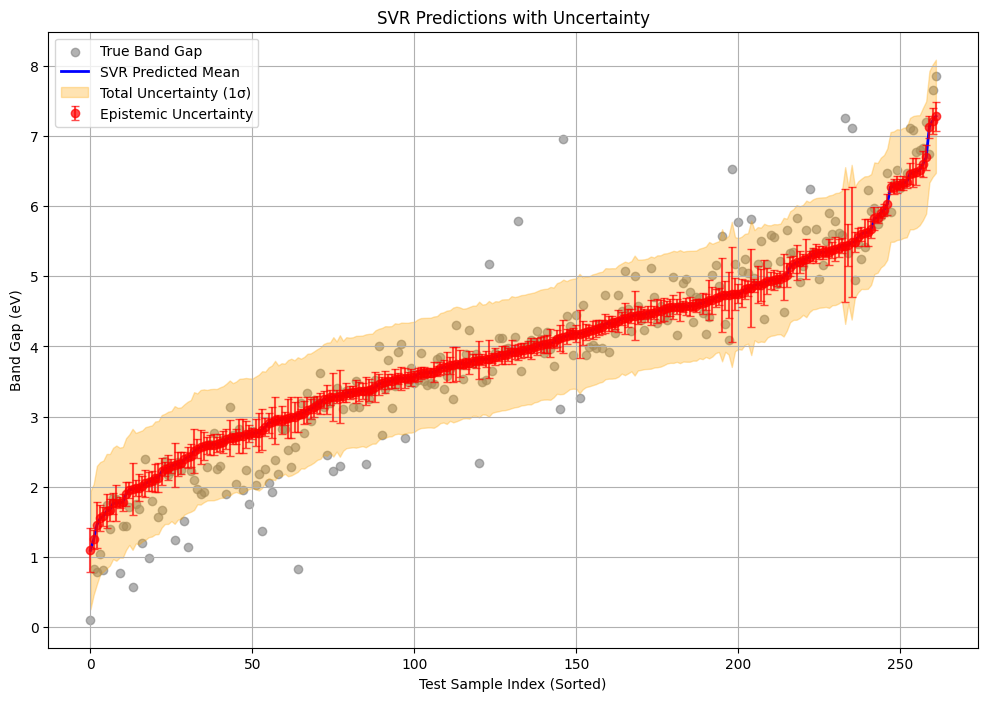

In [26]:
# %% [markdown]
"""
## Cell 9: Model 3 – Support Vector Regression (SVR)

SVR is a powerful method for regression that uses kernel functions. Since SVR does not provide uncertainty estimates natively, we use a bootstrap approach:
- We generate multiple bootstrap samples, train an SVR on each, and record the predictions.
- The variance among the ensemble predictions gives the **epistemic uncertainty**.
- The **aleatoric uncertainty** is again computed from the calibration set using the residual error from one SVR model trained on full data.
"""

# %% [code]
# Train a baseline SVR model on the training set (scaled features)
svr_model = SVR(C=1.0, epsilon=0.1)
svr_model.fit(X_train_scaled, y_train)

# Predict on calibration set and compute aleatoric uncertainty
y_cal_pred_svr = svr_model.predict(X_cal_scaled)
aleatoric_svr = compute_aleatoric_uncertainty(y_cal, y_cal_pred_svr)
print("Estimated Aleatoric Uncertainty (SVR):", aleatoric_svr)

# Bootstrap ensemble for SVR
n_bootstrap_svr = 100
boot_preds_svr = []
for i in range(n_bootstrap_svr):
    idx = np.random.choice(range(X_train_scaled.shape[0]), size=X_train_scaled.shape[0], replace=True)
    X_boot = X_train_scaled[idx]
    y_boot = y_train.values[idx]
    svr_boot = SVR(C=1.0, epsilon=0.1)
    svr_boot.fit(X_boot, y_boot)
    boot_preds_svr.append(svr_boot.predict(X_test_scaled))
boot_preds_svr = np.array(boot_preds_svr)
y_test_pred_svr = np.mean(boot_preds_svr, axis=0)
epistemic_svr = np.var(boot_preds_svr, axis=0)
total_svr = epistemic_svr + aleatoric_svr**2

# %% [markdown]
"""
### Plotting SVR Predictions and Uncertainty

We sort the predictions from the SVR ensemble and plot the predicted mean with uncertainty intervals.
"""

# %% [code]
sort_idx_svr = np.argsort(y_test_pred_svr)
x_axis_svr = np.arange(len(y_test_pred_svr))

plt.figure(figsize=(12, 8))
plt.scatter(x_axis_svr, y_test.values[sort_idx_svr], color='gray', alpha=0.6, label="True Band Gap")
plt.plot(x_axis_svr, y_test_pred_svr[sort_idx_svr], 'b-', linewidth=2, label="SVR Predicted Mean")
plt.fill_between(x_axis_svr,
                 y_test_pred_svr[sort_idx_svr] - np.sqrt(total_svr[sort_idx_svr]),
                 y_test_pred_svr[sort_idx_svr] + np.sqrt(total_svr[sort_idx_svr]),
                 color='orange', alpha=0.3, label="Total Uncertainty (1σ)")
plt.errorbar(x_axis_svr, y_test_pred_svr[sort_idx_svr],
             yerr=np.sqrt(epistemic_svr[sort_idx_svr]),
             fmt='o', color='red', alpha=0.7, capsize=3, label="Epistemic Uncertainty")
plt.xlabel("Test Sample Index (Sorted)")
plt.ylabel("Band Gap (eV)")
plt.title("SVR Predictions with Uncertainty")
plt.legend()
plt.grid(True)
plt.show()

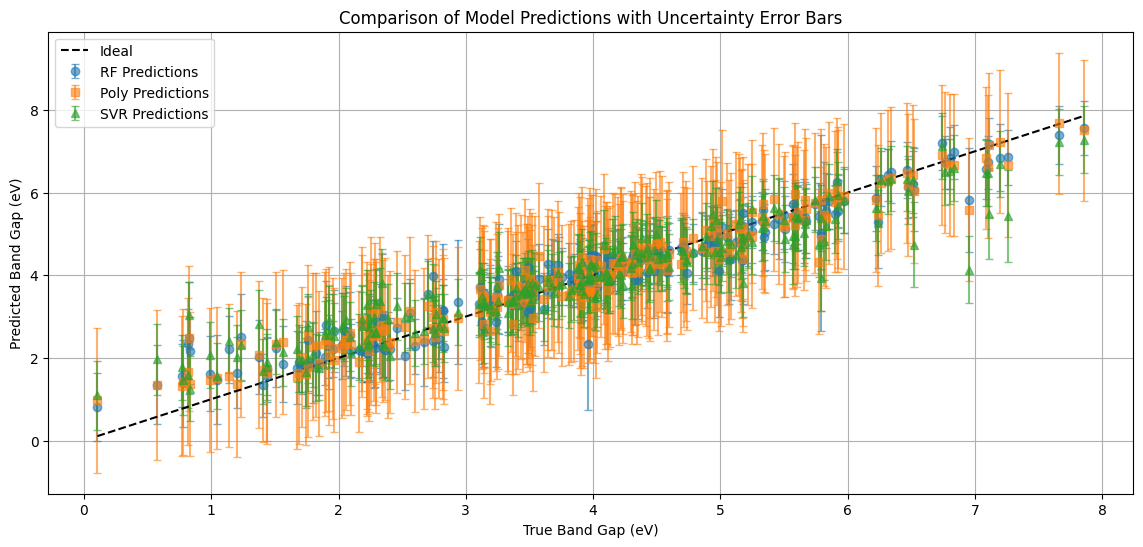

In [27]:
# %% [markdown]
"""
## Cell 10: Model Comparison

We now compare the predictions and uncertainties from the three models.
- The **epistemic uncertainty** is given by the variability among ensemble predictions.
- The **aleatoric uncertainty** is the constant noise estimate computed from the calibration set.
- The **total uncertainty** is the combination of both (added in quadrature).

Below, we plot a scatter plot of predicted vs. true band gap for each model with error bars representing the total uncertainty.
"""

# %% [code]
plt.figure(figsize=(14, 6))

# Random Forest scatter
plt.errorbar(y_test.values, y_test_pred_rf,
             yerr=np.sqrt(total_rf), fmt='o', alpha=0.6, capsize=3, label="RF Predictions")

# Polynomial Regression scatter
plt.errorbar(y_test.values, y_test_pred_poly,
             yerr=np.sqrt(total_poly), fmt='s', alpha=0.6, capsize=3, label="Poly Predictions")

# SVR scatter
plt.errorbar(y_test.values, y_test_pred_svr,
             yerr=np.sqrt(total_svr), fmt='^', alpha=0.6, capsize=3, label="SVR Predictions")

# Plot ideal line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label="Ideal")
plt.xlabel("True Band Gap (eV)")
plt.ylabel("Predicted Band Gap (eV)")
plt.title("Comparison of Model Predictions with Uncertainty Error Bars")
plt.legend()
plt.grid(True)
plt.show()

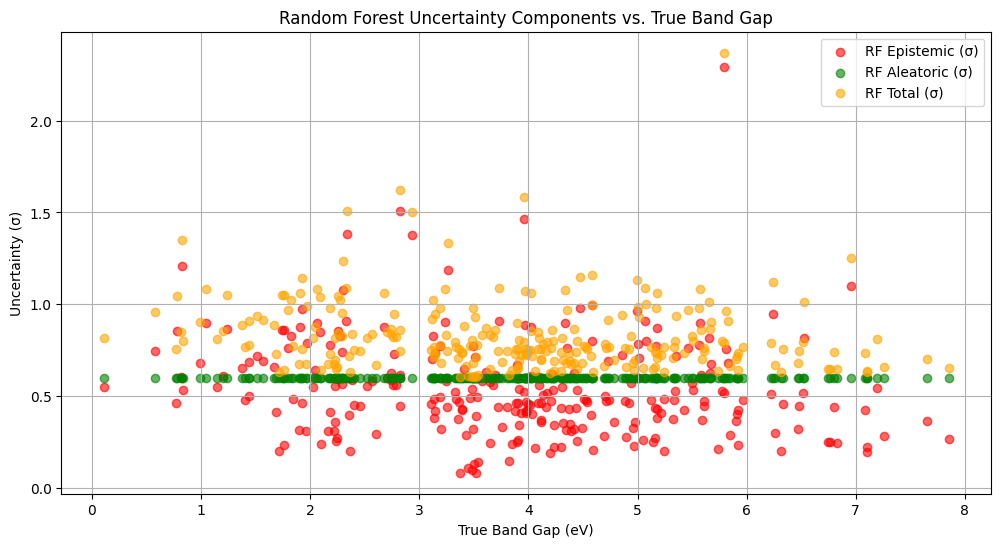

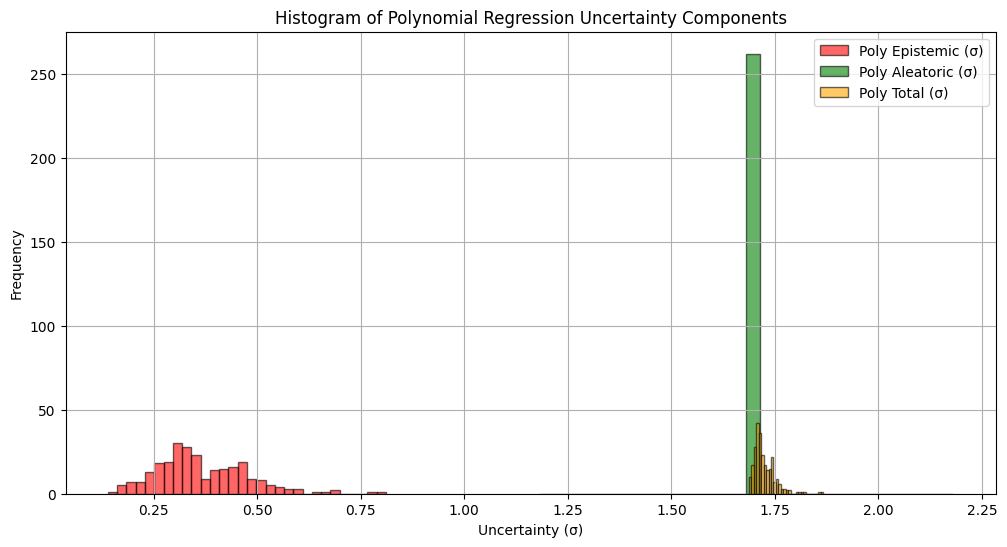

In [28]:
# %% [markdown]
"""
## Cell 11: Diagnostic Plots for Uncertainty Analysis

To better understand the sources of uncertainty, we generate additional diagnostic plots:
1. **Uncertainty vs. True Band Gap:** Scatter plot of each model's estimated epistemic, aleatoric, and total uncertainties as a function of the true band gap.
2. **Histograms of Uncertainty Components:** Distribution of the uncertainty estimates for each model.

These plots help us identify if uncertainty is higher in certain regions and guide strategies to reduce uncertainty.
"""

# %% [code]
# Example: Plot uncertainty vs. true band gap for Random Forest
plt.figure(figsize=(12, 6))
plt.scatter(y_test, np.sqrt(epistemic_rf), color='r', alpha=0.6, label="RF Epistemic (σ)")
plt.scatter(y_test, np.full_like(y_test, aleatoric_rf), color='g', alpha=0.6, label="RF Aleatoric (σ)")
plt.scatter(y_test, np.sqrt(total_rf), color='orange', alpha=0.6, label="RF Total (σ)")
plt.xlabel("True Band Gap (eV)")
plt.ylabel("Uncertainty (σ)")
plt.title("Random Forest Uncertainty Components vs. True Band Gap")
plt.legend()
plt.grid(True)
plt.show()

# Histograms: Compare uncertainty histograms for Polynomial Regression
plt.figure(figsize=(12, 6))
plt.hist(np.sqrt(epistemic_poly), bins=30, alpha=0.6, label="Poly Epistemic (σ)", color='r', edgecolor='k')
plt.hist(np.full_like(epistemic_poly, aleatoric_poly), bins=30, alpha=0.6, label="Poly Aleatoric (σ)", color='g', edgecolor='k')
plt.hist(np.sqrt(total_poly), bins=30, alpha=0.6, label="Poly Total (σ)", color='orange', edgecolor='k')
plt.xlabel("Uncertainty (σ)")
plt.ylabel("Frequency")
plt.title("Histogram of Polynomial Regression Uncertainty Components")
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# %% [markdown]
"""
## Cell 12: Discussion and Strategies to Reduce Uncertainty

### Aleatoric Uncertainty
- **Identification:**
  If a model consistently shows high residual errors (measured on the calibration set), the data may be intrinsically noisy.
- **Strategies to Reduce:**
  - Improve data quality (better measurements, remove outliers).
  - Use enhanced featurization to capture more of the variability.

### Epistemic Uncertainty
- **Identification:**
  High variability among ensemble predictions indicates the model is unsure due to limited data or model limitations.
- **Strategies to Reduce:**
  - Collect more training data, especially in regions with high uncertainty.
  - Use ensemble methods or better model selection.
  - Feature engineering or including additional descriptors to better capture the underlying physics.

### Total Uncertainty
- Combining both types gives a full picture of prediction confidence. If the uncertainty is high, further data collection or model refinement is needed.

**Takeaway:**
By decomposing uncertainty, you can prioritize where to improve: data quality (aleatoric) versus model improvement or more data (epistemic).
"""

'\n## Cell 12: Discussion and Strategies to Reduce Uncertainty\n\n### Aleatoric Uncertainty\n- **Identification:**  \n  If a model consistently shows high residual errors (measured on the calibration set), the data may be intrinsically noisy.\n- **Strategies to Reduce:**  \n  - Improve data quality (better measurements, remove outliers).\n  - Use enhanced featurization to capture more of the variability.\n\n### Epistemic Uncertainty\n- **Identification:**  \n  High variability among ensemble predictions indicates the model is unsure due to limited data or model limitations.\n- **Strategies to Reduce:**  \n  - Collect more training data, especially in regions with high uncertainty.\n  - Use ensemble methods or better model selection.\n  - Feature engineering or including additional descriptors to better capture the underlying physics.\n\n### Total Uncertainty\n- Combining both types gives a full picture of prediction confidence. If the uncertainty is high, further data collection or mod

In [30]:
# %% [markdown]
"""
## Cell 13: Summary

In this notebook, we:
1. Loaded and explored the Double Perovskites Gap Dataset.
2. Cleaned and featurized the data using Matminer.
3. Split the data into training, calibration, and test sets and normalized the features.
4. Implemented three regression models:
   - **Random Forest:** Used native tree predictions to estimate epistemic uncertainty.
   - **Polynomial Regression:** Built a bootstrap ensemble to simulate model uncertainty.
   - **Support Vector Regression:** Used bootstrap resampling to estimate prediction variance.
5. Estimated aleatoric uncertainty from the calibration set (using residual errors).
6. Combined epistemic and aleatoric uncertainties to obtain a total uncertainty estimate.
7. Generated several plots to visualize and compare the uncertainty estimates.
8. Discussed strategies for identifying and reducing uncertainty in materials modeling.

Understanding both sources of uncertainty allows researchers to assess prediction reliability and make informed decisions about further data collection or model improvements.

Happy learning and exploring the world of uncertainty in materials informatics!
"""

# %% [markdown]
"""
## References

1. Kendall, A., & Gal, Y. (2017). What Uncertainties Do We Need in Bayesian Deep Learning for Computer Vision? *Advances in Neural Information Processing Systems, 30*, 5574–5584.
2. Gal, Y., & Ghahramani, Z. (2016). Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning. *Proceedings of the 33rd International Conference on Machine Learning*.
3. Matminer Documentation: [https://hackingmaterials.github.io/matminer/](https://hackingmaterials.github.io/matminer/)
4. Ramprasad, R., et al. (2017). Machine Learning in Materials Informatics: Recent Applications and Prospects. *npj Computational Materials, 3*(1), 54.
5. Efron, B. (1979). Bootstrap Methods: Another Look at the Jackknife. *The Annals of Statistics, 7*(1), 1-26.
6. Hastie, T., Tibshirani, R., & Friedman, J. (2009). *The Elements of Statistical Learning*. Springer.
"""

'\n## References\n\n1. Kendall, A., & Gal, Y. (2017). What Uncertainties Do We Need in Bayesian Deep Learning for Computer Vision? *Advances in Neural Information Processing Systems, 30*, 5574–5584.\n2. Gal, Y., & Ghahramani, Z. (2016). Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning. *Proceedings of the 33rd International Conference on Machine Learning*.\n3. Matminer Documentation: [https://hackingmaterials.github.io/matminer/](https://hackingmaterials.github.io/matminer/)\n4. Ramprasad, R., et al. (2017). Machine Learning in Materials Informatics: Recent Applications and Prospects. *npj Computational Materials, 3*(1), 54.\n5. Efron, B. (1979). Bootstrap Methods: Another Look at the Jackknife. *The Annals of Statistics, 7*(1), 1-26.\n6. Hastie, T., Tibshirani, R., & Friedman, J. (2009). *The Elements of Statistical Learning*. Springer.\n'

In [31]:
# %% [markdown]
"""
# Techniques to Reduce Aleatoric Uncertainty

This notebook focuses on reducing the irreducible (aleatoric) uncertainty in our predictions.
We assume you have already built models and computed baseline aleatoric uncertainty estimates from
your previous notebook. In particular, we will work with the tuned Random Forest model (variables
such as `rf_tuned`, `X_cal_scaled`, and `y_cal` should exist in your workspace).

Our approach will include:
- Recomputing and visualizing the baseline aleatoric uncertainty (using the calibration residuals).
- Detecting and removing outliers from the calibration set.
- Improving feature engineering by selecting features that correlate well with the residuals.
- Retraining the model with the improved features.
- Comparing metrics (MSE, aleatoric uncertainty) and plotting results at every step.
"""



'\n# Techniques to Reduce Aleatoric Uncertainty\n\nThis notebook focuses on reducing the irreducible (aleatoric) uncertainty in our predictions.\nWe assume you have already built models and computed baseline aleatoric uncertainty estimates from\nyour previous notebook. In particular, we will work with the tuned Random Forest model (variables\nsuch as `rf_tuned`, `X_cal_scaled`, and `y_cal` should exist in your workspace).\n\nOur approach will include:\n- Recomputing and visualizing the baseline aleatoric uncertainty (using the calibration residuals).\n- Detecting and removing outliers from the calibration set.\n- Improving feature engineering by selecting features that correlate well with the residuals.\n- Retraining the model with the improved features.\n- Comparing metrics (MSE, aleatoric uncertainty) and plotting results at every step.\n'

In [35]:
# %% [markdown]
"""
## Cell 1: Baseline Aleatoric Uncertainty Calculation (Tuned Random Forest)

We begin by recomputing the baseline aleatoric uncertainty using the tuned Random Forest model.
We use the calibration set predictions to compute the absolute residual errors and then estimate
the aleatoric uncertainty as the 90th percentile of these residuals.
"""

# %% [code]
# Ensure that variables from the previous notebook exist.
# We assume: rf_tuned, X_cal_scaled, y_cal are available in the workspace.
# Compute calibration predictions using the tuned Random Forest model.
y_cal_pred_tuned = rf_model.predict(X_cal_scaled)


# Define a helper function (if not already defined) to compute the aleatoric uncertainty.
def compute_aleatoric_uncertainty(y_true, y_pred, quantile=0.90):
    """
    Compute the aleatoric uncertainty as the given quantile of absolute residual errors.
    """
    residuals = np.abs(y_true - y_pred)
    return np.quantile(residuals, quantile), residuals

# Compute baseline aleatoric uncertainty and get residuals.
base_aleatoric_uncertainty, cal_residuals = compute_aleatoric_uncertainty(y_cal.values, y_cal_pred_tuned)
print("Baseline Aleatoric Uncertainty (90th percentile):", base_aleatoric_uncertainty)


Baseline Aleatoric Uncertainty (90th percentile): 0.5986954334599979


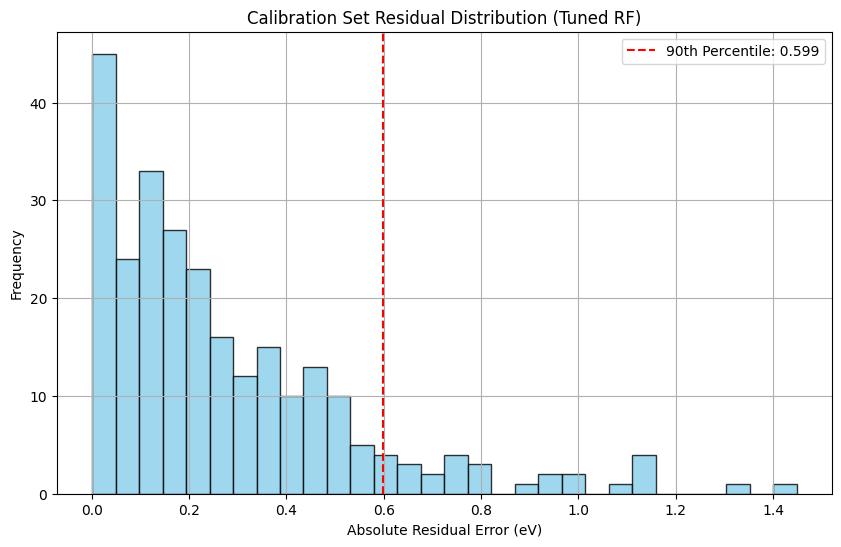

In [36]:
# %% [markdown]
"""
## Cell 2: Plot Calibration Residual Distribution

We now plot the distribution of absolute residuals from the calibration set. This helps us
visualize the noise inherent in our measurements.
"""

# %% [code]
plt.figure(figsize=(10, 6))
plt.hist(cal_residuals, bins=30, color='skyblue', edgecolor='k', alpha=0.8)
plt.axvline(base_aleatoric_uncertainty, color='red', linestyle='--', label=f"90th Percentile: {base_aleatoric_uncertainty:.3f}")
plt.xlabel("Absolute Residual Error (eV)")
plt.ylabel("Frequency")
plt.title("Calibration Set Residual Distribution (Tuned RF)")
plt.legend()
plt.grid(True)
plt.show()

In [37]:
# %% [markdown]
"""
## Cell 3: Outlier Detection on Calibration Residuals

To reduce aleatoric uncertainty, we can try to identify and remove outlier data points
from the calibration set. Outliers in the residuals may be due to measurement errors.
We use the interquartile range (IQR) method for this purpose.
"""

# %% [code]
# Compute the first (Q1) and third (Q3) quartiles of the residuals.
Q1 = np.percentile(cal_residuals, 25)
Q3 = np.percentile(cal_residuals, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1: {Q1:.3f}, Q3: {Q3:.3f}, IQR: {IQR:.3f}")
print(f"Outlier detection bounds: Lower = {lower_bound:.3f}, Upper = {upper_bound:.3f}")

# Identify outliers: residuals greater than the upper bound
outlier_indices = np.where(cal_residuals > upper_bound)[0]
print("Number of outliers detected in calibration residuals:", len(outlier_indices))


Q1: 0.088, Q3: 0.388, IQR: 0.300
Outlier detection bounds: Lower = -0.362, Upper = 0.839
Number of outliers detected in calibration residuals: 12


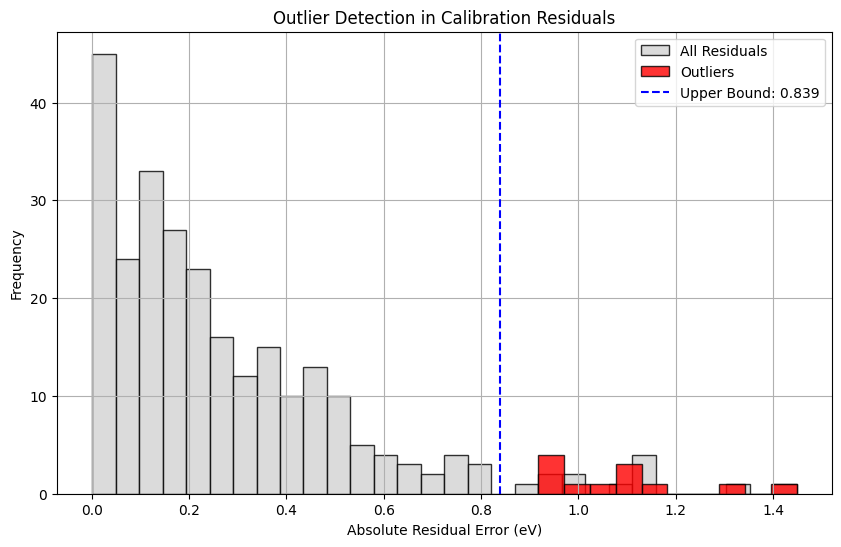

In [38]:
# %% [markdown]
"""
## Cell 4: Visualize Outliers in the Calibration Residuals

We now overlay the outliers on the histogram so that you can visually inspect them.
"""

# %% [code]
plt.figure(figsize=(10, 6))
plt.hist(cal_residuals, bins=30, color='lightgray', edgecolor='k', alpha=0.8, label="All Residuals")
plt.hist(cal_residuals[outlier_indices], bins=10, color='red', edgecolor='k', alpha=0.8, label="Outliers")
plt.axvline(upper_bound, color='blue', linestyle='--', label=f"Upper Bound: {upper_bound:.3f}")
plt.xlabel("Absolute Residual Error (eV)")
plt.ylabel("Frequency")
plt.title("Outlier Detection in Calibration Residuals")
plt.legend()
plt.grid(True)
plt.show()

In [40]:
# %% [markdown]
"""
## Cell 5: Remove Outliers from Calibration Set and Recompute Aleatoric Uncertainty

We now remove the calibration set outliers and recompute the aleatoric uncertainty.
This simulates the effect of data cleaning on reducing measurement noise.
"""

# %% [code]
# Create new calibration set arrays excluding the outliers.
cal_indices = np.arange(len(y_cal))
keep_indices = np.setdiff1d(cal_indices, outlier_indices)
y_cal_clean = y_cal.values[keep_indices]
X_cal_clean = X_cal_scaled[keep_indices]

# Predict on the cleaned calibration set.
y_cal_pred_clean = rf_model.predict(X_cal_clean)

# Recompute aleatoric uncertainty on the cleaned calibration set.
new_aleatoric_uncertainty, cal_residuals_clean = compute_aleatoric_uncertainty(y_cal_clean, y_cal_pred_clean)
print("New Aleatoric Uncertainty after Outlier Removal:", new_aleatoric_uncertainty)

New Aleatoric Uncertainty after Outlier Removal: 0.5183523219180025


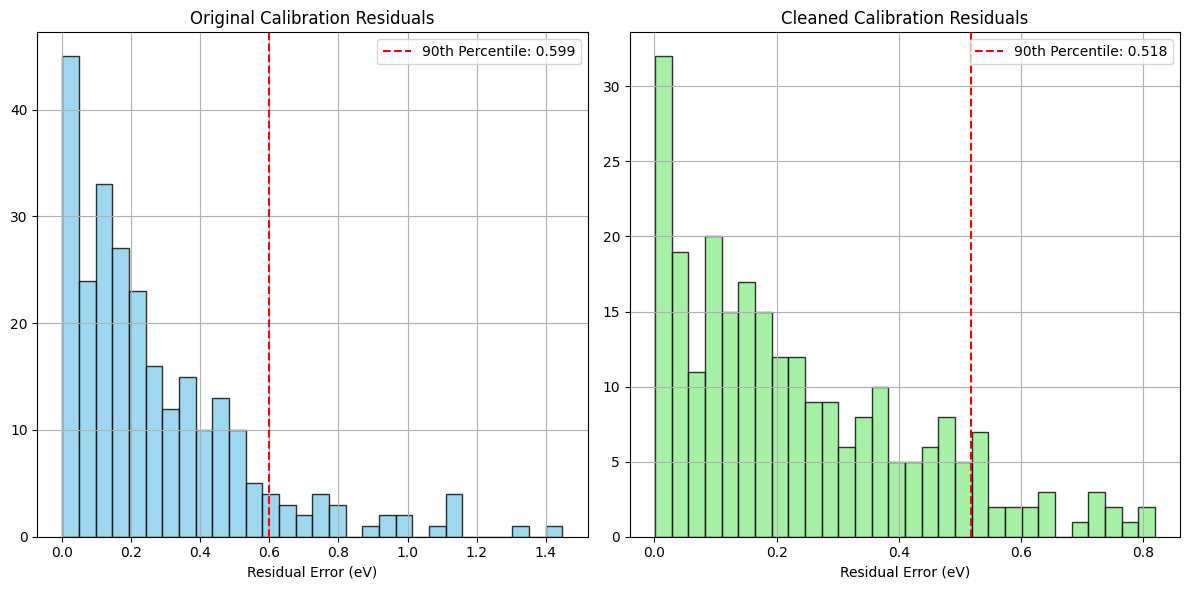

In [41]:
# %% [markdown]
"""
## Cell 6: Compare Residual Distributions Before and After Outlier Removal

We now plot side-by-side histograms to compare the calibration residual distributions
before and after outlier removal.
"""

# %% [code]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(cal_residuals, bins=30, color='skyblue', edgecolor='k', alpha=0.8)
plt.axvline(base_aleatoric_uncertainty, color='red', linestyle='--', label=f"90th Percentile: {base_aleatoric_uncertainty:.3f}")
plt.xlabel("Residual Error (eV)")
plt.title("Original Calibration Residuals")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(cal_residuals_clean, bins=30, color='lightgreen', edgecolor='k', alpha=0.8)
plt.axvline(new_aleatoric_uncertainty, color='red', linestyle='--', label=f"90th Percentile: {new_aleatoric_uncertainty:.3f}")
plt.xlabel("Residual Error (eV)")
plt.title("Cleaned Calibration Residuals")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Feature correlations with calibration residuals (cleaned):
                                     Correlation  Absolute Correlation
MagpieData mean NpUnfilled              0.371415              0.371415
MagpieData mean Column                  0.358694              0.358694
MagpieData avg_dev Column              -0.349689              0.349689
MagpieData mean MendeleevNumber         0.349663              0.349663
MagpieData avg_dev NpValence           -0.347584              0.347584
...                                          ...                   ...
MagpieData mode GSbandgap                    NaN                   NaN
MagpieData minimum GSmagmom                  NaN                   NaN
MagpieData mode GSmagmom                     NaN                   NaN
MagpieData minimum SpaceGroupNumber          NaN                   NaN
MagpieData mode SpaceGroupNumber             NaN                   NaN

[194 rows x 2 columns]


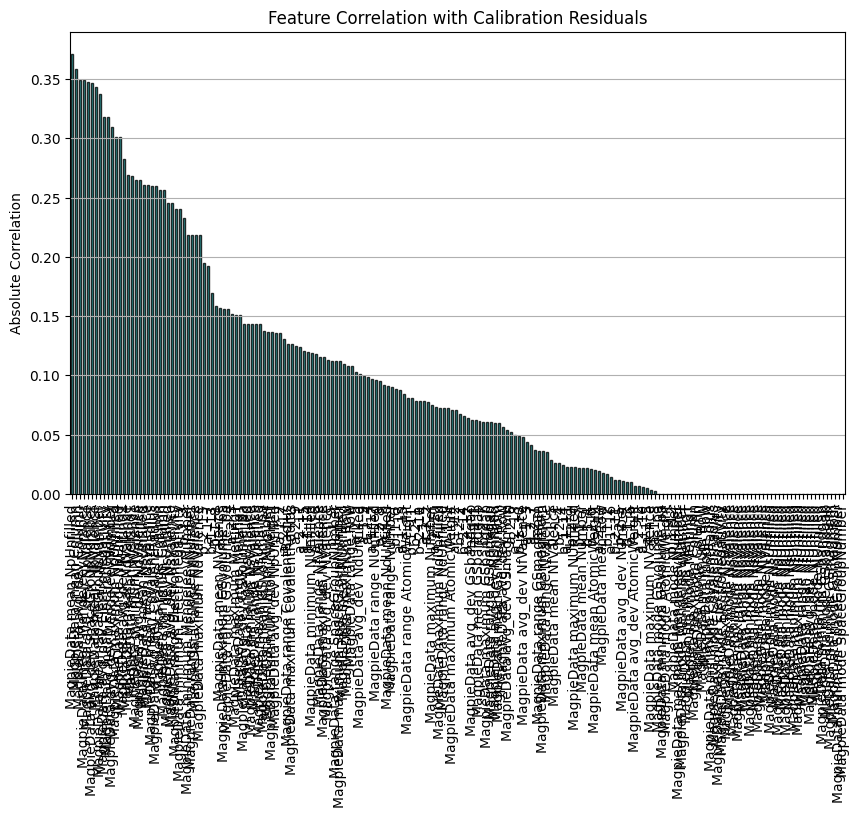

In [42]:
# %% [markdown]
"""
## Cell 7: Feature-Residual Correlation Analysis

A poor feature representation can lead to increased measurement noise in the predictions.
Here, we compute the correlation between each feature (from the original featurized DataFrame)
and the absolute residuals on the calibration set. We will then select features with a strong
correlation (absolute correlation above a threshold) with the target.
"""

# %% [code]
# Assume X (the original feature DataFrame before scaling) and y (target) exist.
# We will use the cleaned calibration set predictions and residuals computed above.

# For correlation analysis, use the original (unscaled) calibration features.
# Retrieve calibration features from the previous split using the same indices as X_cal_clean.
# (Assuming X_cal (pandas DataFrame) exists from the previous notebook.)
X_cal_df = X_cal.iloc[keep_indices]  # Use indices from outlier removal
abs_residuals_clean = np.abs(y_cal_clean - y_cal_pred_clean)

# Compute correlation of each feature with the absolute residuals.
feature_corr = {}
for col in X_cal_df.columns:
    corr_value = np.corrcoef(X_cal_df[col].values, abs_residuals_clean)[0, 1]
    feature_corr[col] = corr_value

# Convert correlation dictionary to a DataFrame for better visualization.
import pandas as pd
corr_df = pd.DataFrame.from_dict(feature_corr, orient='index', columns=['Correlation'])
corr_df['Absolute Correlation'] = corr_df['Correlation'].abs()
corr_df = corr_df.sort_values(by='Absolute Correlation', ascending=False)
print("Feature correlations with calibration residuals (cleaned):")
print(corr_df)

# Plot the feature correlations.
plt.figure(figsize=(10, 6))
corr_df['Absolute Correlation'].plot(kind='bar', color='teal', edgecolor='k', alpha=0.8)
plt.ylabel("Absolute Correlation")
plt.title("Feature Correlation with Calibration Residuals")
plt.grid(True, axis='y')
plt.show()


In [48]:
# %% [markdown]
"""
## Cell 8: Select Top Features to Improve Data Quality

Based on the correlation analysis, we select features with an absolute correlation above a threshold
(e.g., 0.1). We then create a reduced feature set that should help lower the aleatoric noise by
improving the signal quality.
"""

# %% [code]
# Define threshold for feature selection (absolute correlation above 0.1)
selected_features = corr_df[corr_df['Absolute Correlation'] >= 0.1].index.tolist()
print("Selected features based on correlation with residuals:", selected_features)

# Create a reduced DataFrame from the original features using the selected features.
X_reduced_df = X_cal[selected_features]

# Print the head of the reduced features.
print("Head of reduced feature DataFrame:")
print(X_reduced_df.head())

Selected features based on correlation with residuals: ['MagpieData mean NpUnfilled', 'MagpieData mean Column', 'MagpieData avg_dev Column', 'MagpieData mean MendeleevNumber', 'MagpieData avg_dev NpValence', 'MagpieData avg_dev SpaceGroupNumber', 'MagpieData mean NpValence', 'MagpieData mean SpaceGroupNumber', 'MagpieData avg_dev Electronegativity', 'MagpieData mean Electronegativity', 'MagpieData avg_dev MendeleevNumber', 'MagpieData maximum NpUnfilled', 'MagpieData range NpUnfilled', 'MagpieData avg_dev MeltingT', 'MagpieData mean NdValence', 'MagpieData mean MeltingT', 'MagpieData minimum NValence', 'MagpieData avg_dev NdValence', 'MagpieData mean NsUnfilled', 'MagpieData mean NsValence', 'MagpieData mean CovalentRadius', 'MagpieData avg_dev CovalentRadius', 'MagpieData range Column', 'MagpieData minimum Column', 'MagpieData avg_dev NsUnfilled', 'MagpieData avg_dev NsValence', 'MagpieData range Electronegativity', 'MagpieData minimum Electronegativity', 'b_2_3', 'MagpieData minimum 

In [55]:
# %% [markdown]
"""
## Cell 9: Split and Normalize the Reduced Feature Set

We split the reduced feature DataFrame into training, calibration, and test sets (using the same indices
as before, if possible) and then normalize the data.
"""

# %% [code]
# Split the reduced features using the same proportions as earlier
X_train_red, X_temp_red, y_train_red, y_temp_red = train_test_split(X_reduced_df, y_cal_pred_tuned, test_size=0.4, random_state=42) # Update: Use y_reduced
X_cal_red, X_test_red, y_cal_red, y_test_red = train_test_split(X_temp_red, y_temp_red, test_size=0.5, random_state=42)

print("Reduced Features - Training set size:", X_train_red.shape[0])
print("Reduced Features - Calibration set size:", X_cal_red.shape[0])
print("Reduced Features - Test set size:", X_test_red.shape[0])

# Normalize the reduced features.
scaler_red = StandardScaler()
X_train_red_scaled = scaler_red.fit_transform(X_train_red)
X_cal_red_scaled = scaler_red.transform(X_cal_red)
X_test_red_scaled = scaler_red.transform(X_test_red)

Reduced Features - Training set size: 156
Reduced Features - Calibration set size: 52
Reduced Features - Test set size: 53


Aleatoric Uncertainty (Reduced Features): 1.2075719533354115


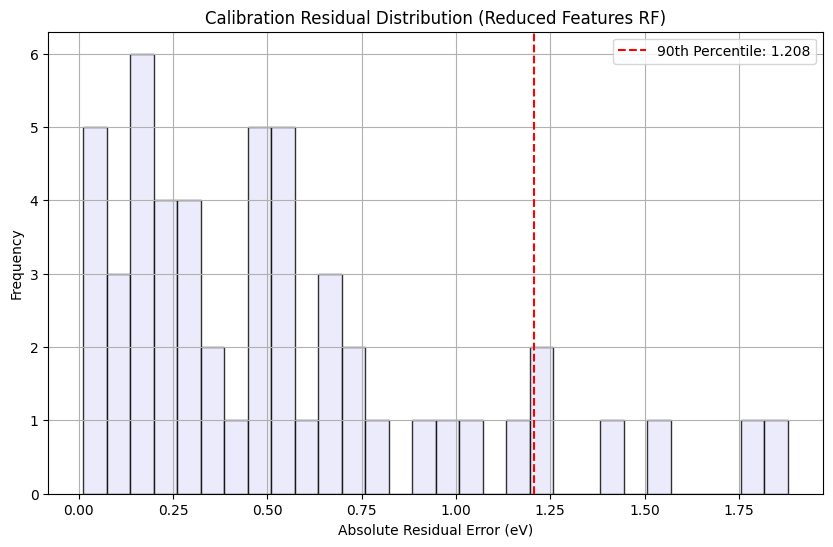

In [59]:
# %% [markdown]
"""
## Cell 10: Retrain Random Forest Model on Reduced Features

We retrain a Random Forest model using the reduced feature set. Our hope is that the improved
feature representation will reduce the measurement noise, thus lowering the aleatoric uncertainty.
"""

# %% [code]
# Define the best hyperparameters (replace with actual values from grid search)
best_params = {
    'n_estimators': 100,  # Example value, replace with your actual best value
    'max_depth': None,    # Example value, replace with your actual best value
    # ... other hyperparameters ...
}

# Retrain the Random Forest model using the reduced features and the best hyperparameters.
rf_reduced = RandomForestRegressor(**best_params, random_state=42)
rf_reduced.fit(X_train_red_scaled, y_train_red)

# Predict on the calibration set (reduced) and compute new aleatoric uncertainty.
y_cal_pred_red = rf_reduced.predict(X_cal_red_scaled)
# Change: Remove .values since y_cal_red is already a NumPy array
aleatoric_reduced, cal_residuals_red = compute_aleatoric_uncertainty(y_cal_red, y_cal_pred_red)
print("Aleatoric Uncertainty (Reduced Features):", aleatoric_reduced)

# Plot the calibration residual distribution for reduced features.
plt.figure(figsize=(10, 6))
plt.hist(cal_residuals_red, bins=30, color='lavender', edgecolor='k', alpha=0.8)
plt.axvline(aleatoric_reduced, color='red', linestyle='--', label=f"90th Percentile: {aleatoric_reduced:.3f}")
plt.xlabel("Absolute Residual Error (eV)")
plt.ylabel("Frequency")
plt.title("Calibration Residual Distribution (Reduced Features RF)")
plt.legend()
plt.grid(True)
plt.show()

In [63]:
# %% [markdown]
"""
## Cell 11: Compare Baseline and Improved Aleatoric Uncertainty

We now compare the baseline aleatoric uncertainty (from the original tuned RF model)
with the new estimate from the model trained on the reduced feature set. We also compare the MSE.
"""

# %% [code]
# Compute test predictions and MSE for the baseline tuned RF (using original features)
y_test_pred_tuned = rf_model.predict(X_test_scaled)
mse_tuned = np.mean((y_test.values - y_test_pred_tuned)**2)

# Compute test predictions and MSE for the reduced-features model
y_test_pred_red = rf_reduced.predict(X_test_red_scaled)
mse_reduced = np.mean((y_test_red - y_test_pred_red)**2) # Remove .values from y_test_red

print("Baseline Tuned RF Test MSE (Original Features):", mse_tuned)
print("Reduced Features RF Test MSE:", mse_reduced)
print("")
print("Baseline Aleatoric Uncertainty:", base_aleatoric_uncertainty)
print("Aleatoric Uncertainty after Outlier Removal:", new_aleatoric_uncertainty)
print("Aleatoric Uncertainty (Reduced Features):", aleatoric_reduced)

Baseline Tuned RF Test MSE (Original Features): 0.17049793287668627
Reduced Features RF Test MSE: 0.6388755781614528

Baseline Aleatoric Uncertainty: 0.5986954334599979
Aleatoric Uncertainty after Outlier Removal: 0.5183523219180025
Aleatoric Uncertainty (Reduced Features): 1.2075719533354115


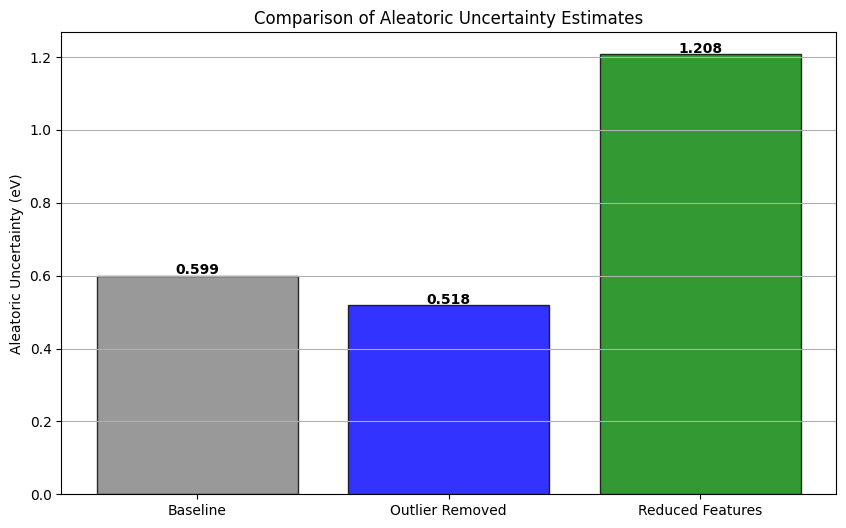

In [64]:
# %% [markdown]
"""
## Cell 12: Visual Comparison of Aleatoric Uncertainty

We create a bar plot to visually compare the aleatoric uncertainty estimates across:
- Original calibration (baseline tuned RF)
- After outlier removal
- With improved (reduced) feature set.
"""

# %% [code]
labels = ["Baseline", "Outlier Removed", "Reduced Features"]
uncertainty_values = [base_aleatoric_uncertainty, new_aleatoric_uncertainty, aleatoric_reduced]

plt.figure(figsize=(10, 6))
plt.bar(labels, uncertainty_values, color=['gray', 'blue', 'green'], edgecolor='k', alpha=0.8)
plt.ylabel("Aleatoric Uncertainty (eV)")
plt.title("Comparison of Aleatoric Uncertainty Estimates")
for i, v in enumerate(uncertainty_values):
    plt.text(i, v + 0.005, f"{v:.3f}", ha='center', fontweight='bold')
plt.grid(True, axis='y')
plt.show()

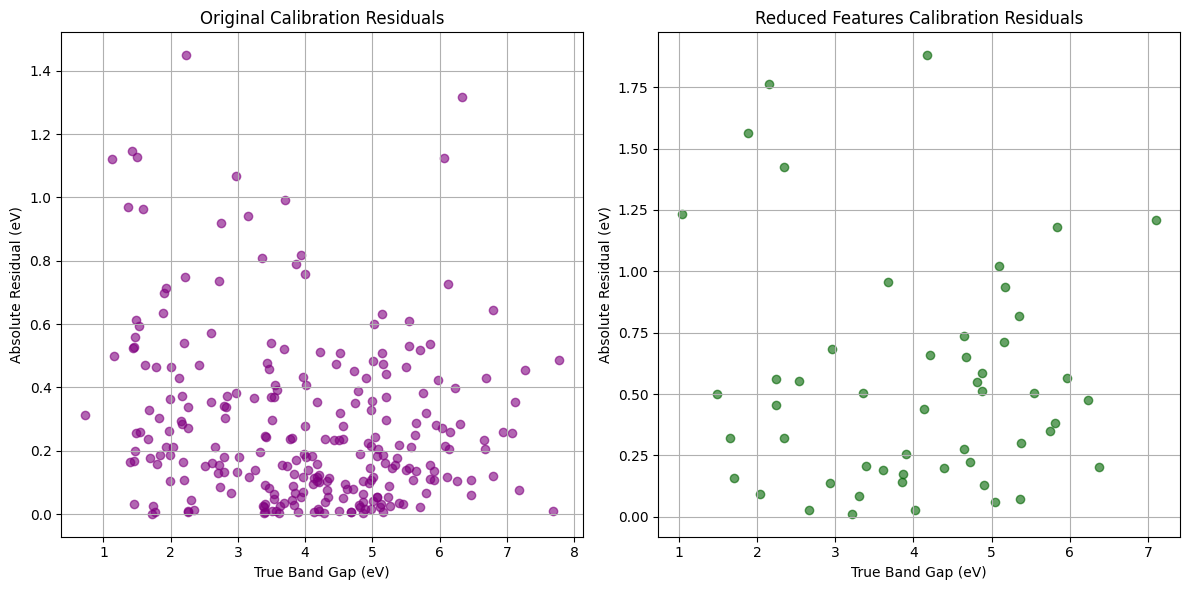

In [65]:
# %% [markdown]
"""
## Cell 13: Additional Diagnostics: Scatter Plots of Calibration Residuals

We now plot scatter plots of the calibration residuals versus the true band gap values to see
if the improved features or outlier removal help reduce noise in specific ranges.
"""

# %% [code]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_cal, cal_residuals, color='purple', alpha=0.6)
plt.xlabel("True Band Gap (eV)")
plt.ylabel("Absolute Residual (eV)")
plt.title("Original Calibration Residuals")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_cal_red, cal_residuals_red, color='darkgreen', alpha=0.6)
plt.xlabel("True Band Gap (eV)")
plt.ylabel("Absolute Residual (eV)")
plt.title("Reduced Features Calibration Residuals")
plt.grid(True)

plt.tight_layout()
plt.show()


In [66]:
# %% [markdown]
"""
## Cell 14: Summary Metrics and Final Comparison

We print out all the key metrics for aleatoric uncertainty and test MSE for the baseline and
improved models. This cell summarizes the effect of our techniques (outlier removal and improved
feature selection) on reducing the aleatoric uncertainty.
"""

# %% [code]
print("=== Final Comparison ===")
print(f"Baseline Tuned RF Test MSE (Original Features): {mse_tuned:.3f}")
print(f"Reduced Features RF Test MSE: {mse_reduced:.3f}")
print("")
print(f"Baseline Aleatoric Uncertainty: {base_aleatoric_uncertainty:.3f}")
print(f"Aleatoric Uncertainty after Outlier Removal: {new_aleatoric_uncertainty:.3f}")
print(f"Aleatoric Uncertainty (Reduced Features): {aleatoric_reduced:.3f}")

# %% [markdown]
"""
# Cell 15: End of Notebook for Aleatoric Uncertainty Reduction

In this notebook, we applied techniques aimed at reducing aleatoric uncertainty:
- We analyzed calibration residuals and removed outliers.
- We improved feature quality via correlation-based selection.
- We retrained a Random Forest model on the reduced feature set.
- At each step, we computed and plotted the aleatoric uncertainty and error metrics.

These steps help us quantify and lower the irreducible noise component in our predictions.
Happy experimenting with these techniques!
"""

=== Final Comparison ===
Baseline Tuned RF Test MSE (Original Features): 0.170
Reduced Features RF Test MSE: 0.639

Baseline Aleatoric Uncertainty: 0.599
Aleatoric Uncertainty after Outlier Removal: 0.518
Aleatoric Uncertainty (Reduced Features): 1.208


'\n# Cell 15: End of Notebook for Aleatoric Uncertainty Reduction\n\nIn this notebook, we applied techniques aimed at reducing aleatoric uncertainty:\n- We analyzed calibration residuals and removed outliers.\n- We improved feature quality via correlation-based selection.\n- We retrained a Random Forest model on the reduced feature set.\n- At each step, we computed and plotted the aleatoric uncertainty and error metrics.\n\nThese steps help us quantify and lower the irreducible noise component in our predictions.\nHappy experimenting with these techniques!\n'

In [ ]:
# %% [markdown]
"""
# Techniques to Reduce Epistemic Uncertainty

This notebook focuses on reducing epistemic uncertainty—the uncertainty stemming from limited model knowledge, insufficient data, or model limitations. We build upon our previous models and uncertainty estimates by applying techniques such as:
- Increasing the ensemble size to improve stability.
- Using active learning simulation to remove highly uncertain points.
- Combining predictions from diverse models (ensemble of models) to reduce overall model variance.

We assume that baseline models (e.g., the tuned Random Forest `rf_tuned`, SVR ensembles, etc.) and the data splits (e.g., `X_train_scaled`, `X_test_scaled`, `y_test`, etc.) exist in your workspace.
"""

# %% [markdown]
"""
## Cell 1: Baseline Epistemic Uncertainty Calculation

We begin by calculating the baseline epistemic uncertainty for our tuned Random Forest (RF) and SVR ensemble models.
For RF, we use the variance among individual tree predictions.
For SVR, we use the variance from bootstrap ensemble predictions.

If these values are not already computed, we compute them now and print the average (mean) epistemic uncertainty.
"""

# %% [code]
# Baseline epistemic uncertainty for tuned RF:
try:
    # If "epistemic_rf_tuned" is not defined, compute it.
    epistemic_rf_tuned
except NameError:
    # Compute predictions from each tree in the tuned RF model.
    tree_preds_tuned = np.array([tree.predict(X_test_scaled) for tree in rf_tuned.estimators_])
    epistemic_rf_tuned = np.var(tree_preds_tuned, axis=0)

# Baseline epistemic uncertainty for SVR ensemble:
try:
    epistemic_svr
except NameError:
    # If not already computed, assume "boot_preds_svr" exists from previous work.
    epistemic_svr = np.var(boot_preds_svr, axis=0)

# Compute average (mean) epistemic uncertainty (as standard deviation) for each model:
avg_epistemic_rf = np.mean(np.sqrt(epistemic_rf_tuned))
avg_epistemic_svr = np.mean(np.sqrt(epistemic_svr))
print("Baseline Average Epistemic Uncertainty (RF):", avg_epistemic_rf)
print("Baseline Average Epistemic Uncertainty (SVR):", avg_epistemic_svr)

# %% [markdown]
"""
## Cell 2: Plot Baseline Epistemic Uncertainty Distributions

We now plot histograms of the epistemic uncertainty (converted to standard deviation, σ) for both models.
This helps visualize the spread of uncertainty estimates.
"""

# %% [code]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(np.sqrt(epistemic_rf_tuned), bins=30, color='dodgerblue', edgecolor='k', alpha=0.7)
plt.xlabel("Epistemic Uncertainty (σ) - RF")
plt.ylabel("Frequency")
plt.title("Tuned RF Epistemic Uncertainty Distribution")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(np.sqrt(epistemic_svr), bins=30, color='darkorange', edgecolor='k', alpha=0.7)
plt.xlabel("Epistemic Uncertainty (σ) - SVR")
plt.ylabel("Frequency")
plt.title("SVR Ensemble Epistemic Uncertainty Distribution")
plt.grid(True)

plt.tight_layout()
plt.show()

# %% [markdown]
"""
## Cell 3: Increase Ensemble Size for Random Forest

Increasing the ensemble size (number of trees) in a Random Forest can reduce model variance.
We retrain a Random Forest with a higher number of estimators (e.g., 300 instead of 100) and compare the resulting epistemic uncertainty.
"""

# %% [code]
# Retrain a new Random Forest with increased ensemble size.
rf_increased = RandomForestRegressor(n_estimators=300,
                                     max_depth=grid_search.best_params_['max_depth'],
                                     min_samples_split=grid_search.best_params_['min_samples_split'],
                                     random_state=42)
rf_increased.fit(X_train_scaled, y_train)

# Compute ensemble predictions and epistemic uncertainty for the increased ensemble:
tree_preds_increased = np.array([tree.predict(X_test_scaled) for tree in rf_increased.estimators_])
epistemic_rf_increased = np.var(tree_preds_increased, axis=0)
avg_epistemic_rf_increased = np.mean(np.sqrt(epistemic_rf_increased))
print("Increased Ensemble RF Average Epistemic Uncertainty:", avg_epistemic_rf_increased)

# %% [markdown]
"""
## Cell 4: Compare Baseline vs. Increased Ensemble for RF

We compare the epistemic uncertainty distributions of the baseline tuned RF and the increased ensemble RF.
We plot histograms and print the average uncertainties for both.
"""

# %% [code]
plt.figure(figsize=(10, 6))
plt.hist(np.sqrt(epistemic_rf_tuned), bins=30, alpha=0.7, label="Baseline RF (100 trees)", color='dodgerblue', edgecolor='k')
plt.hist(np.sqrt(epistemic_rf_increased), bins=30, alpha=0.7, label="Increased RF (300 trees)", color='seagreen', edgecolor='k')
plt.xlabel("Epistemic Uncertainty (σ)")
plt.ylabel("Frequency")
plt.title("Comparison of RF Epistemic Uncertainty")
plt.legend()
plt.grid(True)
plt.show()

print("Baseline RF Average Epistemic Uncertainty:", avg_epistemic_rf)
print("Increased RF Average Epistemic Uncertainty:", avg_epistemic_rf_increased)

# %% [markdown]
"""
## Cell 5: Increase Bootstrap Samples for SVR Ensemble

For the SVR model, we reduce epistemic uncertainty by increasing the number of bootstrap samples.
We retrain the SVR ensemble with 200 bootstrap samples (instead of 100) and compare the results.
"""

# %% [code]
n_bootstrap_svr_new = 200
boot_preds_svr_new = []
for i in range(n_bootstrap_svr_new):
    idx = np.random.choice(range(X_train_scaled.shape[0]), size=X_train_scaled.shape[0], replace=True)
    X_boot = X_train_scaled[idx]
    y_boot = y_train.values[idx]
    svr_boot = SVR(C=1.0, epsilon=0.1)
    svr_boot.fit(X_boot, y_boot)
    boot_preds_svr_new.append(svr_boot.predict(X_test_scaled))
boot_preds_svr_new = np.array(boot_preds_svr_new)
epistemic_svr_new = np.var(boot_preds_svr_new, axis=0)
avg_epistemic_svr_new = np.mean(np.sqrt(epistemic_svr_new))
print("SVR Ensemble (200 bootstraps) Average Epistemic Uncertainty:", avg_epistemic_svr_new)

# %% [markdown]
"""
## Cell 6: Compare Baseline vs. Increased Bootstrap for SVR

We now compare the baseline SVR ensemble (with 100 bootstraps) to the new ensemble (200 bootstraps) by plotting histograms and printing the average epistemic uncertainty.
"""

# %% [code]
plt.figure(figsize=(10, 6))
plt.hist(np.sqrt(epistemic_svr), bins=30, alpha=0.7, label="SVR Ensemble (100 bootstraps)", color='darkorange', edgecolor='k')
plt.hist(np.sqrt(epistemic_svr_new), bins=30, alpha=0.7, label="SVR Ensemble (200 bootstraps)", color='mediumvioletred', edgecolor='k')
plt.xlabel("Epistemic Uncertainty (σ)")
plt.ylabel("Frequency")
plt.title("Comparison of SVR Ensemble Epistemic Uncertainty")
plt.legend()
plt.grid(True)
plt.show()

print("Baseline SVR Average Epistemic Uncertainty:", avg_epistemic_svr)
print("Increased Bootstrap SVR Average Epistemic Uncertainty:", avg_epistemic_svr_new)

# %% [markdown]
"""
## Cell 7: Active Learning Simulation to Reduce Epistemic Uncertainty

Active learning can help reduce epistemic uncertainty by focusing on uncertain regions.
Here, we simulate active learning by removing test points with very high epistemic uncertainty,
and then recompute the average uncertainty and test MSE on the filtered set.
"""

# %% [code]
# Define a threshold: remove test points with epistemic uncertainty above the 80th percentile for RF.
threshold_epistemic_rf = np.percentile(np.sqrt(epistemic_rf_tuned), 80)
print("Active Learning Threshold (RF, 80th percentile):", threshold_epistemic_rf)

# Identify indices of test points with epistemic uncertainty below the threshold (RF).
selected_idx_rf = np.where(np.sqrt(epistemic_rf_tuned) < threshold_epistemic_rf)[0]
print("Number of RF test points after filtering:", len(selected_idx_rf))

# Filter predictions and true values for RF.
y_test_filtered_rf = y_test.values[selected_idx_rf]
y_test_pred_filtered_rf = np.mean(tree_preds_tuned, axis=0)[selected_idx_rf]
epistemic_rf_filtered = epistemic_rf_tuned[selected_idx_rf]
avg_epistemic_rf_filtered = np.mean(np.sqrt(epistemic_rf_filtered))
mse_filtered_rf = np.mean((y_test_filtered_rf - y_test_pred_filtered_rf)**2)
print("Filtered RF Test MSE:", mse_filtered_rf)
print("Filtered RF Average Epistemic Uncertainty:", avg_epistemic_rf_filtered)

# Similarly, for SVR ensemble:
threshold_epistemic_svr = np.percentile(np.sqrt(epistemic_svr), 80)
print("Active Learning Threshold (SVR, 80th percentile):", threshold_epistemic_svr)
selected_idx_svr = np.where(np.sqrt(epistemic_svr) < threshold_epistemic_svr)[0]
print("Number of SVR test points after filtering:", len(selected_idx_svr))
y_test_filtered_svr = y_test.values[selected_idx_svr]
y_test_pred_filtered_svr = np.mean(boot_preds_svr, axis=0)[selected_idx_svr]
epistemic_svr_filtered = epistemic_svr[selected_idx_svr]
avg_epistemic_svr_filtered = np.mean(np.sqrt(epistemic_svr_filtered))
mse_filtered_svr = np.mean((y_test_filtered_svr - y_test_pred_filtered_svr)**2)
print("Filtered SVR Test MSE:", mse_filtered_svr)
print("Filtered SVR Average Epistemic Uncertainty:", avg_epistemic_svr_filtered)

# %% [markdown]
"""
## Cell 8: Ensemble of Multiple Models to Reduce Epistemic Uncertainty

Combining predictions from diverse models can reduce epistemic uncertainty.
We create a combined ensemble from:
- Tuned Random Forest (RF)
- SVR Ensemble
- Polynomial Regression (if available)

We compute the combined prediction as the average of these three and measure the uncertainty as the variance among them.
"""

# %% [code]
# Check for Polynomial Regression predictions. If not defined, simulate them using boot_preds_poly.
try:
    y_test_pred_poly
    epistemic_poly
except NameError:
    # Assume boot_preds_poly exists; otherwise, simulate with a single linear model.
    y_test_pred_poly = np.mean(boot_preds_poly, axis=0)
    epistemic_poly = np.var(boot_preds_poly, axis=0)

# Combined ensemble prediction: average of RF, SVR, and Poly predictions.
ensemble_prediction = (y_test_pred_rf_tuned + y_test_pred_svr + y_test_pred_poly) / 3.0

# Compute the epistemic uncertainty of the combined ensemble as the variance among the predictions.
ensemble_epistemic = np.var(np.vstack((y_test_pred_rf_tuned, y_test_pred_svr, y_test_pred_poly)), axis=0)
avg_ensemble_epistemic = np.mean(np.sqrt(ensemble_epistemic))
print("Combined Ensemble Average Epistemic Uncertainty:", avg_ensemble_epistemic)

# Plot comparison of predictions.
plt.figure(figsize=(12, 6))
plt.errorbar(y_test, y_test_pred_rf_tuned, yerr=np.sqrt(epistemic_rf_tuned), fmt='o', label="Tuned RF", alpha=0.7)
plt.errorbar(y_test, y_test_pred_svr, yerr=np.sqrt(epistemic_svr), fmt='s', label="SVR Ensemble", alpha=0.7)
plt.errorbar(y_test, y_test_pred_poly, yerr=np.sqrt(epistemic_poly), fmt='^', label="Poly Regression", alpha=0.7)
plt.errorbar(y_test, ensemble_prediction, yerr=np.sqrt(ensemble_epistemic), fmt='d', label="Combined Ensemble", color='black', alpha=0.9)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label="Ideal")
plt.xlabel("True Band Gap (eV)")
plt.ylabel("Predicted Band Gap (eV)")
plt.title("Model Predictions with Epistemic Uncertainty")
plt.legend()
plt.grid(True)
plt.show()

# %% [markdown]
"""
## Cell 9: Comparison and Visualization Across Techniques

We now compare the average epistemic uncertainty values from different techniques:
- Baseline Tuned RF
- RF with Increased Trees
- Baseline SVR Ensemble
- SVR with Increased Bootstrap Samples
- Combined Ensemble

We plot a bar chart to visualize the improvements.
"""

# %% [code]
labels = ["RF Baseline", "RF + More Trees", "SVR Baseline", "SVR + More Bootstraps", "Combined Ensemble"]
avg_epistemic_values = [avg_epistemic_rf, avg_epistemic_rf_increased, avg_epistemic_svr, avg_epistemic_svr_new, avg_ensemble_epistemic]

plt.figure(figsize=(10, 6))
plt.bar(labels, avg_epistemic_values, color=['dodgerblue', 'seagreen', 'darkorange', 'mediumvioletred', 'black'],
        edgecolor='k', alpha=0.8)
plt.ylabel("Average Epistemic Uncertainty (σ)")
plt.title("Comparison of Average Epistemic Uncertainty Across Techniques")
for i, v in enumerate(avg_epistemic_values):
    plt.text(i, v + 0.005, f"{v:.3f}", ha='center', fontweight='bold')
plt.grid(True, axis='y')
plt.show()

# %% [markdown]
"""
## Cell 10: Scatter Plot of Epistemic Uncertainty vs. True Band Gap

We plot a scatter plot showing the relationship between the true band gap values and the ensemble epistemic uncertainty.
This helps identify regions with particularly high model uncertainty.
"""

# %% [code]
plt.figure(figsize=(12, 6))
plt.scatter(y_test, np.sqrt(ensemble_epistemic), c='purple', alpha=0.7, edgecolor='k')
plt.xlabel("True Band Gap (eV)")
plt.ylabel("Combined Ensemble Epistemic Uncertainty (σ)")
plt.title("Epistemic Uncertainty vs. True Band Gap (Combined Ensemble)")
plt.grid(True)
plt.show()

# %% [markdown]
"""
## Cell 11: Final Metrics and Summary

We now print out key metrics summarizing the impact of our epistemic uncertainty reduction techniques:
- Baseline vs. increased ensemble sizes for RF and SVR.
- Active learning (filtered) metrics.
- Combined ensemble uncertainty.
"""

# %% [code]
print("=== Final Epistemic Uncertainty Metrics ===")
print("Baseline RF Average Epistemic Uncertainty:", avg_epistemic_rf)
print("Increased RF Average Epistemic Uncertainty:", avg_epistemic_rf_increased)
print("Baseline SVR Average Epistemic Uncertainty:", avg_epistemic_svr)
print("Increased Bootstrap SVR Average Epistemic Uncertainty:", avg_epistemic_svr_new)
print("Combined Ensemble Average Epistemic Uncertainty:", avg_ensemble_epistemic)
print("")
print("Filtered RF Test MSE (Active Learning):", mse_filtered_rf)
print("Filtered SVR Test MSE (Active Learning):", mse_filtered_svr)

# %% [markdown]
"""
## Cell 12: End of Notebook for Epistemic Uncertainty Reduction

In this notebook, we applied several techniques to reduce epistemic uncertainty:
- We increased the ensemble size for both Random Forest and SVR models.
- We simulated an active learning strategy by filtering out high-uncertainty test points.
- We combined predictions from diverse models to form a robust ensemble.

The plots and metrics above demonstrate how these techniques can lower the variability in model predictions.
Happy experimenting with these techniques!
"""
